In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import warnings
import joblib
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [3]:
df_train = pd.read_csv('/kaggle/input/datasets/ericrhadoophop/widsdata2023/train_data.csv')
df_test = pd.read_csv('/kaggle/input/datasets/ericrhadoophop/widsdata2023/test_data.csv')
df_sample = pd.read_csv('/kaggle/input/datasets/ericrhadoophop/widsdata2023/sample_solution.csv')

In [4]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 352.24 Mb (50.1% reduction)


In [5]:
df_train.shape

(375734, 246)

In [6]:
df_train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.099324,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.271945,198.077499,10.951795,11.072930,10.339542,10.573793,9.403106,10.689975,...,37.316212,36.204590,38.456974,25.287085,31.944239,34.161930,27.048275,25.846542,25.068645,25.112333
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,18.740000,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,33.389999,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


In [7]:
print("=== Dimensional Information of the Dataset ===")
print(f"Original dataset shape: {df_train.shape}")
print(f"Sample size: {df_train.shape[0]}")
print(f"Feature size: {df_train.shape[1]}")

# View target feature
target_col = 'contest-tmp2m-14d__tmp2m'
if target_col in df_train.columns:
    print(f"\ntarget featire '{target_col}' in the dataset")
    print(f"Target Variable Statistics:")
    print(df_train[target_col].describe())
else:
    print(f"\nWarning: target feature '{target_col}' not in the dataset")

# View Feature Type Distribution
print("\n=== Distribution of Feature Types ===")
print(df_train.dtypes.value_counts())

# View Missing Values
print("\n=== Missing Value Statistics ===")
missing_percent = df_train.isnull().sum() / len(df_train) * 100
missing_stats = pd.DataFrame({
    'Number of Missing Values': df_train.isnull().sum(),
    'Proportion of Missing Values (%)': missing_percent
})
print(f"Number of features with missing values: {(missing_percent > 0).sum()}")
print(f"Missing values in 9 features")
print(missing_stats[missing_stats['Number of Missing Values'] > 0].sort_values('Proportion of Missing Values (%)', ascending=False).head(10))

=== Dimensional Information of the Dataset ===
Original dataset shape: (375734, 246)
Sample size: 375734
Feature size: 246

target featire 'contest-tmp2m-14d__tmp2m' in the dataset
Target Variable Statistics:
count    375734.000000
mean         11.858567
std           9.867457
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238781
Name: contest-tmp2m-14d__tmp2m, dtype: float64

=== Distribution of Feature Types ===
float32    240
int8         3
object       2
int32        1
Name: count, dtype: int64

=== Missing Value Statistics ===
Number of features with missing values: 8
Missing values in 9 features
                         Number of Missing Values  \
nmme0-tmp2m-34w__ccsm30                     15934   
nmme0-prate-56w__ccsm30                     15934   
ccsm30                                      15934   
nmme0-prate-34w__ccsm30                     15934   
nmme-prate-56w__ccsm3                       10280   
nmme-tmp2m-5

# 1.Count missing entire rows and missing specific fields, then output the analysis results to a CSV file. 

In [8]:
print("=" * 80)
print("Missing Value Type Analysis: Entire Row Missing vs. Specific Field Missing")
print("=" * 80)

def analyze_missing_type(df_train, sample_size=None, show_details=False, max_details=10, 
                         export_csv=False, output_dir="./"):
    """
    Analyzing Missing Value Types
    
    Parameters:
    df_train: DataFrame
    sample_size: Sample size for analysis (None indicates all)
    show_details: Show detailed missing information
    max_details: Maximum number of detailed records displayed
    export_csv: Export the results to a CSV file
    output_dir: CSV File Output Directory
    """
    
    if sample_size and sample_size < len(df_train):
        df_sample = df_train.sample(sample_size, random_state=42).copy()
    else:
        df_sample = df_train.copy()
    
    # Count the number of missing values in each row
    df_sample['missing_count'] = df_sample.isnull().sum(axis=1)
    df_sample['missing_percentage'] = df_sample['missing_count'] / len(df_sample.columns) * 100
    
    # Missing Classification Type
    print(f"\nDataset Shape: {df_sample.shape}")
    print(f"Analyze number of  features: {len(df_sample)}")
    
    # 1. Entirely missing lines (entire lines missing)
    completely_missing = df_sample[df_sample['missing_count'] == len(df_sample.columns)]
    n_complete_missing = len(completely_missing)
    
    print(f"\n1. Entire lines missing:")
    print(f"   Nums: {n_complete_missing:,} rows")
    print(f"   Ratio: {n_complete_missing/len(df_sample)*100:.4f}%")
    
    if n_complete_missing > 0:
        print(f"   Row Index: {completely_missing.index.tolist()[:10]}")
    
    # 2. Partially missing rows (specific fields missing)
    partially_missing = df_sample[(df_sample['missing_count'] > 0) & 
                                  (df_sample['missing_count'] < len(df_sample.columns))]
    n_partial_missing = len(partially_missing)
    
    print(f"\n2. Specific fields missing:")
    print(f"   Nums: {n_partial_missing:,} lines")
    print(f"   Ratio: {n_partial_missing/len(df_sample)*100:.2f}%")
    
    # 3. No missing rows
    no_missing = df_sample[df_sample['missing_count'] == 0]
    n_no_missing = len(no_missing)
    
    print(f"\n3. No missing:")
    print(f"   Nums: {n_no_missing:,} lines")
    print(f"   Ratio: {n_no_missing/len(df_sample)*100:.2f}%")
    
    # 4. Analyze the distribution of missing values in partially missing rows
    if n_partial_missing > 0:
        print(f"\n4. Detailed Analysis of Partially Missing Rows:")
        
        # Distribution of Missing Values
        missing_distribution = partially_missing['missing_count'].value_counts().sort_index()
        
        print(f"\n   Distribution of Missing Values:")
        for count, rows in missing_distribution.items():
            percentage = rows / n_partial_missing * 100
            print(f"     Missing {count:3d} fiels: {rows:7,} row ({percentage:5.1f}%)")
            
        # Separate proportionally
        print(f"\n   Distribution of Missing Values:")
        bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        labels = [f'{bins[i]}-{bins[i+1]}%' for i in range(len(bins)-1)]
        
        partially_missing['missing_pct_bin'] = pd.cut(
            partially_missing['missing_percentage'], 
            bins=bins, 
            labels=labels,
            include_lowest=True
        )
        pct_dist = partially_missing['missing_pct_bin'].value_counts().sort_index()
        
        for bin_label, row_count in pct_dist.items():
            if pd.isna(bin_label):
                continue
            percentage = row_count / n_partial_missing * 100
            print(f"     {bin_label}: {row_count:7,} lines ({percentage:5.1f}%)")
    
    # Display detailed information about missing specific fields
    detailed_missing_info = {}
    detailed_missing_df = None  # DataFrame for storing detailed information
    
    if n_partial_missing > 0:
        # Collect detailed information for all missing rows (not just the max_details rows displayed).
        detailed_rows = []
        for idx, row in partially_missing.iterrows():
            # Retrieve the missing field names for this row
            missing_fields = df_sample.columns[df_sample.loc[idx].isnull()].tolist()
            detailed_missing_info[idx] = missing_fields
            
            # Prepare DataFrame row data
            detailed_rows.append({
                'row_index': idx,
                'missing_count': row['missing_count'],
                'missing_percentage': row['missing_percentage'],
                'missing_fields': ', '.join(missing_fields),
                'field_count': len(missing_fields)
            })
        
        # Create a DataFrame containing all details
        detailed_missing_df = pd.DataFrame(detailed_rows)
        
        if show_details:
            print(f"\n5. Detailed records of missing specific fields (Displaying the first {max_details} entries):")
            print("-" * 80)
            
            for i in range(min(max_details, len(detailed_rows))):
                info = detailed_rows[i]
                print(f"Row index: {info['row_index']}")
                print(f"Number of missing fields: {info['missing_count']}个")
                print(f"Name of missing fields: {info['missing_fields'].split(', ')}")
                print("-" * 80)
    
    # Clear temporary columns
    temp_cols = ['missing_count', 'missing_percentage']
    if 'missing_pct_bin' in df_sample.columns:
        temp_cols.append('missing_pct_bin')
    df_sample.drop(temp_cols, axis=1, inplace=True)
    
    # export to csv file
    if export_csv:
        import os
        import time
        
        # check the output dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Timestramp
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        
        # 1. Export summary statistics
        summary_data = {
            'Category': ['Entire row missing','Specific field missing','No missing data','Total'],
            'Quantity (rows)': [n_complete_missing, n_partial_missing, n_no_missing, len(df_sample)],
            'Ratio(%)': [
                n_complete_missing/len(df_sample)*100,
                n_partial_missing/len(df_sample)*100,
                n_no_missing/len(df_sample)*100,
                100.0
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_file = os.path.join(output_dir, f"missing_summary_{timestamp}.csv")
        summary_df.to_csv(summary_file, index=False, encoding='utf-8-sig')
        print(f"\n✓ Summary statistics export to: {summary_file}")
        
        # 2. Export Distribution of Missing Values
        if n_partial_missing > 0 and len(missing_distribution) > 0:
            missing_dist_df = pd.DataFrame({
                'Number of missing fields': missing_distribution.index,
                'Quantity (rows)': missing_distribution.values,
                'Ratio(%)': (missing_distribution.values / n_partial_missing * 100)
            })
            missing_dist_file = os.path.join(output_dir, f"missing_distribution_{timestamp}.csv")
            missing_dist_df.to_csv(missing_dist_file, index=False, encoding='utf-8-sig')
            print(f"✓ Distribution of Missing Values export to: {missing_dist_file}")
        
        # 3. Export detailed missing information
        if detailed_missing_df is not None and not detailed_missing_df.empty:
            detailed_file = os.path.join(output_dir, f"missing_details_{timestamp}.csv")
            detailed_missing_df.to_csv(detailed_file, index=False, encoding='utf-8-sig')
            print(f"✓ Detailed missing information export to: {detailed_file}")
            
            # 4. Export information categorized by missing fields
            # Count the number of rows missing data for each field
            field_missing_counts = {}
            for idx, missing_fields in detailed_missing_info.items():
                for field in missing_fields:
                    if field not in field_missing_counts:
                        field_missing_counts[field] = 0
                    field_missing_counts[field] += 1
            
            field_stats_df = pd.DataFrame({
                'Field name': list(field_missing_counts.keys()),
                'Missing lines': list(field_missing_counts.values()),
                'Percentage of missing rows(%)': [count/n_partial_missing*100 for count in field_missing_counts.values()],
                'Percentage of total samples(%)': [count/len(df_sample)*100 for count in field_missing_counts.values()]
            }).sort_values('Missing lines', ascending=False)
            
            field_stats_file = os.path.join(output_dir, f"field_missing_stats_{timestamp}.csv")
            field_stats_df.to_csv(field_stats_file, index=False, encoding='utf-8-sig')
            print(f"✓ Missing field statistics have been exported to: {field_stats_file}")
        
        # 5. Export an index list for each category row
        indices_df = pd.DataFrame({
            'Entire row missing index': pd.Series(completely_missing.index.tolist()),
            'Index Missing for Specific Field': pd.Series(partially_missing.index.tolist()),
            'Non-missing index': pd.Series(no_missing.index.tolist())
        })
        indices_file = os.path.join(output_dir, f"missing_indices_{timestamp}.csv")
        indices_df.to_csv(indices_file, index=False, encoding='utf-8-sig')
        print(f"✓ Indexes for each category have been exported to: {indices_file}")
        
        # 6. Create Summary Report
        report_file = os.path.join(output_dir, f"missing_analysis_report_{timestamp}.txt")
        with open(report_file, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\n")
            f.write("Missing Value Analysis Report\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Analysis time: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Dataset Shape: {df_sample.shape}\n")
            f.write(f"Number of samples analyzed: {len(df_sample)}\n")
            f.write(f"Total number of fields: {len(df_sample.columns)}\n\n")
            
            f.write("1. Distribution of Missing Types:\n")
            f.write(f"   Entire line missing: {n_complete_missing:,} lines ({n_complete_missing/len(df_sample)*100:.4f}%)\n")
            f.write(f"   Missing specific fields: {n_partial_missing:,} lines ({n_partial_missing/len(df_sample)*100:.2f}%)\n")
            f.write(f"   No missing parts: {n_no_missing:,} lines ({n_no_missing/len(df_sample)*100:.2f}%)\n\n")
            
            if n_partial_missing > 0:
                f.write("2. Detailed Statistics for Rows Missing Specific Fields:\n")
                f.write("   Distribution of Missing Values:\n")
                for count, rows in missing_distribution.items():
                    percentage = rows / n_partial_missing * 100
                    f.write(f"     Missing {count:3d} fields: {rows:7,} rows ({percentage:5.1f}%)\n")
        
        print(f"✓ The analysis report has been exported to: {report_file}")
        print(f"\nAll result files have been saved to the directory.: {output_dir}")
    
    return {
        'completely_missing': completely_missing.index.tolist(),
        'partially_missing': partially_missing.index.tolist(),
        'no_missing': no_missing.index.tolist(),
        'detailed_missing_info': detailed_missing_info if (show_details or export_csv) else None,
        'detailed_missing_df': detailed_missing_df if export_csv else None,
        'sample_data': df_sample if export_csv else None
    }

# Analyze missing data types and export results to CSV
missing_type_results = analyze_missing_type(
    df_train, 
    sample_size=int(len(df_train)), 
    show_details=True,       # Show Details
    max_details=10,          # Display the first 10 detailed records
    export_csv=True,         # Export to CSV file
    output_dir="./missing_analysis_results"  # Output Directory
)


Missing Value Type Analysis: Entire Row Missing vs. Specific Field Missing

Dataset Shape: (375734, 248)
Analyze number of  features: 375734

1. Entire lines missing:
   Nums: 0 rows
   Ratio: 0.0000%

2. Specific fields missing:
   Nums: 23,130 lines
   Ratio: 6.16%

3. No missing:
   Nums: 352,604 lines
   Ratio: 93.84%

4. Detailed Analysis of Partially Missing Rows:

   Distribution of Missing Values:
     Missing   2 fiels:   8,738 row ( 37.8%)
     Missing   4 fiels:   7,196 row ( 31.1%)
     Missing   6 fiels:   1,028 row (  4.4%)
     Missing   8 fiels:   6,168 row ( 26.7%)

   Distribution of Missing Values:
     0-10%:  23,130 lines (100.0%)
     10-20%:       0 lines (  0.0%)
     20-30%:       0 lines (  0.0%)
     30-40%:       0 lines (  0.0%)
     40-50%:       0 lines (  0.0%)
     50-60%:       0 lines (  0.0%)
     60-70%:       0 lines (  0.0%)
     70-80%:       0 lines (  0.0%)
     80-90%:       0 lines (  0.0%)
     90-100%:       0 lines (  0.0%)

5. Detailed re

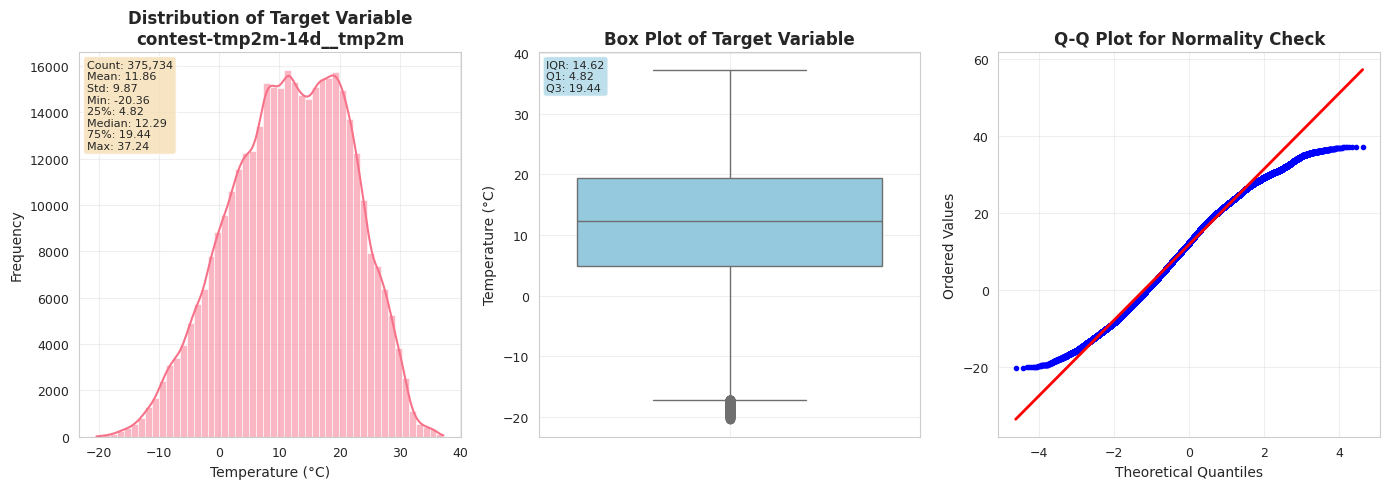


Target variable statistics:
  Skewness: -0.2276
  Kurtosis: -0.5172


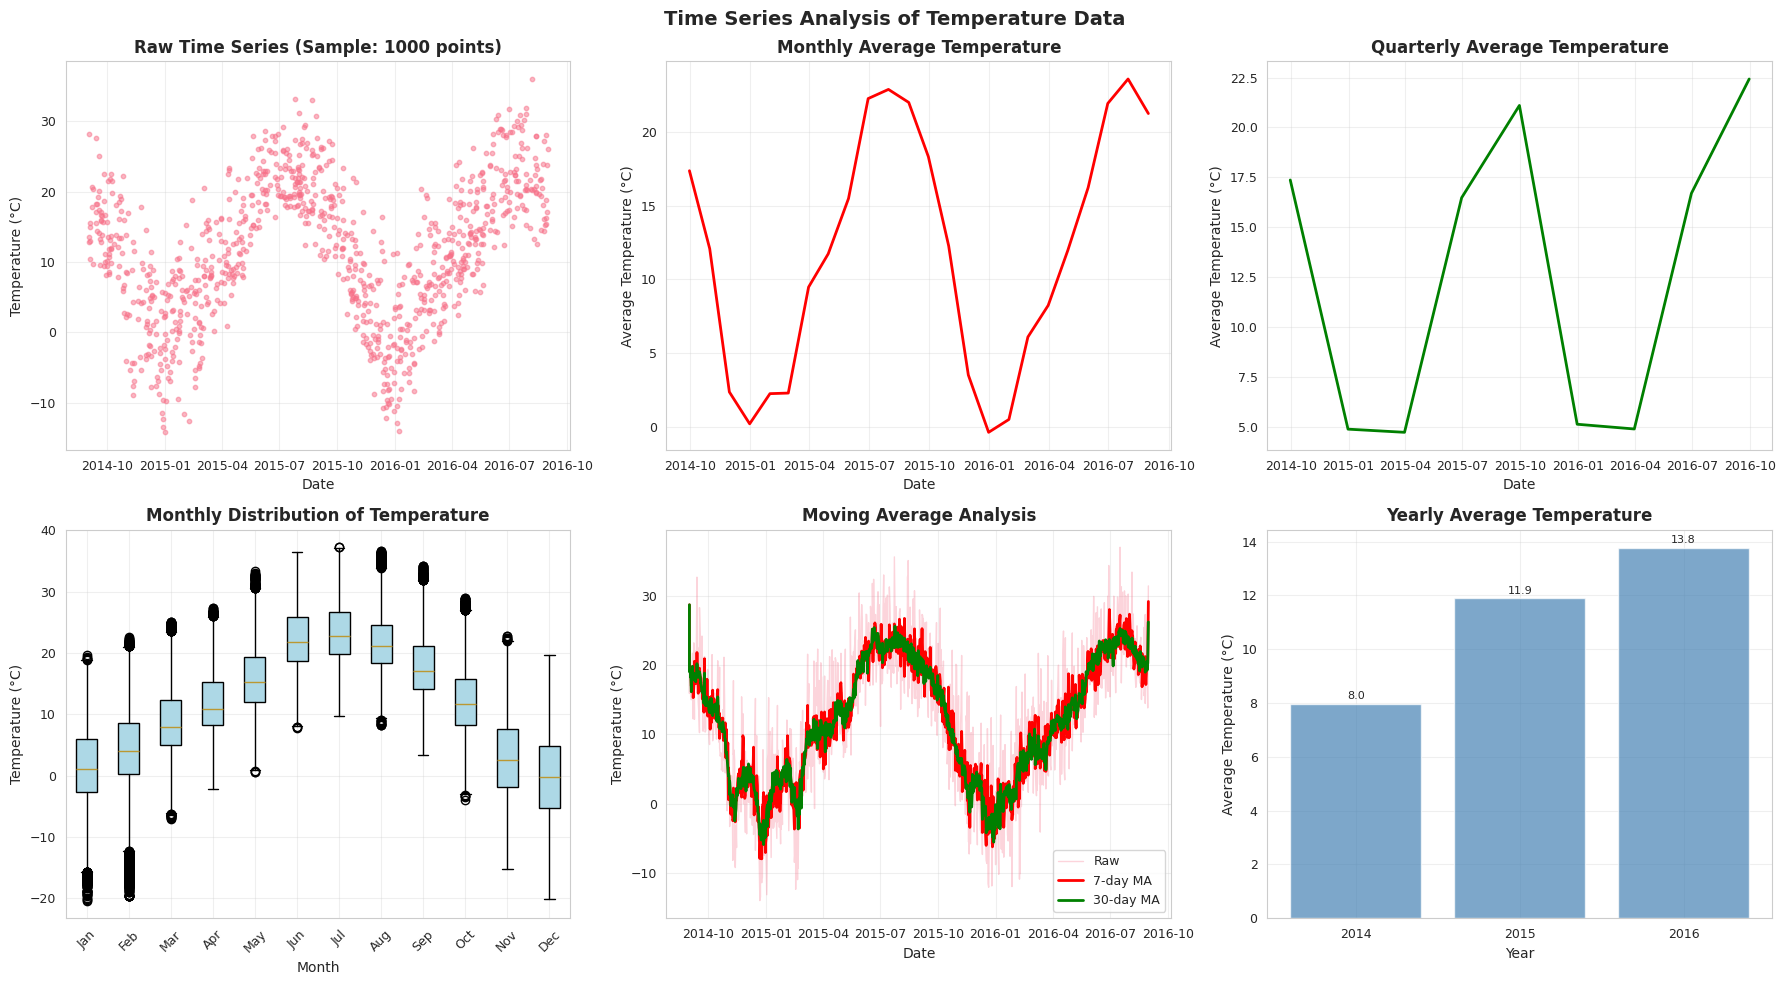


MISSING VALUES ANALYSIS

Missing Values Summary:
  Total missing values: 101,772
  Percentage of all values: 0.11%
  Features with missing values: 8
  Features without missing values: 238
  Max missing percentage: 4.24%
  Average missing percentage: 0.11016260162601627%


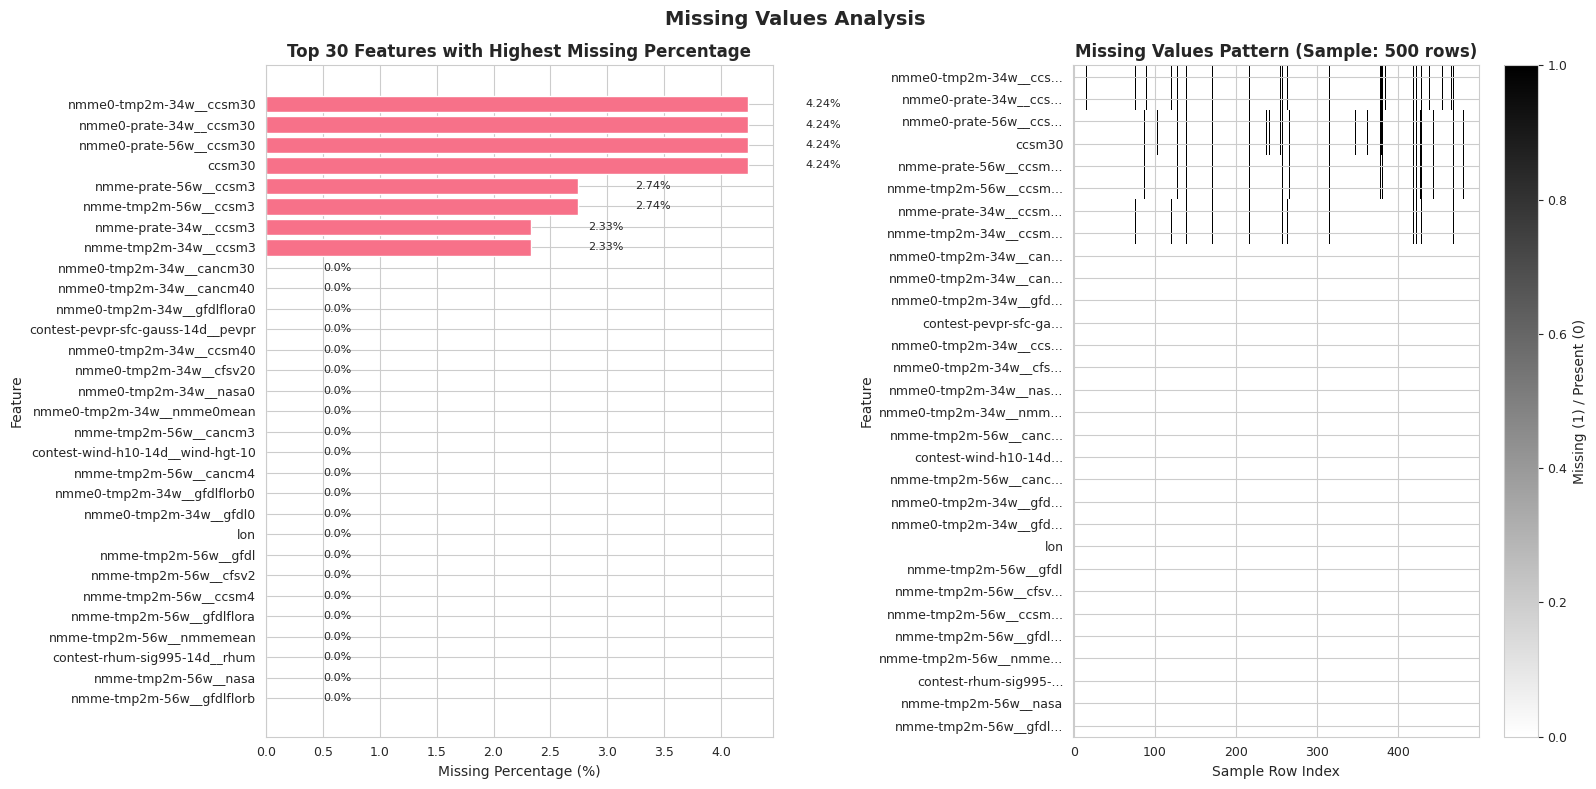


Top 5 features with most missing values:
  1. nmme0-tmp2m-34w__ccsm30: 4.24% missing
  2. nmme0-prate-34w__ccsm30: 4.24% missing
  3. nmme0-prate-56w__ccsm30: 4.24% missing
  4. ccsm30: 4.24% missing
  5. nmme-prate-56w__ccsm3: 2.74% missing


In [9]:
class DataOverviewVisualizerEN:
    """Data Overview and Basic Information Visualizer"""
    
    def __init__(self, df, target_col):
        self.df = df.copy()
        self.target_col = target_col
        self.setup_style()
        
    def setup_style(self):
        """Setup visualization style"""
        # Use standard matplotlib settings for English output
        plt.rcParams.update({
            'font.size': 10,
            'axes.titlesize': 12,
            'axes.labelsize': 10,
            'xtick.labelsize': 9,
            'ytick.labelsize': 9,
            'legend.fontsize': 9
        })
        sns.set_style("whitegrid")
        sns.set_palette("husl")
    
    def visualize_basic_info(self):
        """Basic dataset information"""
        print("\n" + "="*60)
        print("DATASET BASIC INFORMATION")
        print("="*60)
        print(f"Shape: {self.df.shape}")
        print(f"Target variable: {self.target_col}")
        
        target_stats = self.df[self.target_col].describe()
        print(f"\nTarget variable statistics:")
        print(f"  Mean: {target_stats['mean']:.2f}")
        print(f"  Std: {target_stats['std']:.2f}")
        print(f"  Min: {target_stats['min']:.2f}")
        print(f"  25%: {target_stats['25%']:.2f}")
        print(f"  50% (Median): {target_stats['50%']:.2f}")
        print(f"  75%: {target_stats['75%']:.2f}")
        print(f"  Max: {target_stats['max']:.2f}")
        
        if 'startdate' in self.df.columns:
            self.df['startdate'] = pd.to_datetime(self.df['startdate'])
            print(f"\nDate range: {self.df['startdate'].min()} to {self.df['startdate'].max()}")
            print(f"Number of unique dates: {self.df['startdate'].nunique()}")
        
        if all(col in self.df.columns for col in ['lat', 'lon']):
            print(f"\nGeographical range:")
            print(f"  Latitude: [{self.df['lat'].min()}, {self.df['lat'].max()}]")
            print(f"  Longitude: [{self.df['lon'].min()}, {self.df['lon'].max()}]")
        
        # Data types information
        print(f"\nData types:")
        dtype_counts = self.df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} columns")
        
        # Missing values summary
        missing_total = self.df.isnull().sum().sum()
        missing_percentage = (missing_total / (self.df.shape[0] * self.df.shape[1])) * 100
        print(f"\nMissing values:")
        print(f"  Total missing values: {missing_total}")
        print(f"  Missing percentage: {missing_percentage:.2f}%")
        
        return self.df
    
    def plot_target_distribution(self, figsize=(14, 5)):
        """Target variable distribution plot"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 1. Histogram with KDE
        sns.histplot(self.df[self.target_col].dropna(), bins=50, kde=True, ax=axes[0])
        axes[0].set_title(f'Distribution of Target Variable\n{self.target_col}', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Temperature (°C)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)
        
        # Add statistics box
        stats = self.df[self.target_col].describe()
        stats_text = (f"Count: {int(stats['count']):,}\n"
                     f"Mean: {stats['mean']:.2f}\n"
                     f"Std: {stats['std']:.2f}\n"
                     f"Min: {stats['min']:.2f}\n"
                     f"25%: {stats['25%']:.2f}\n"
                     f"Median: {stats['50%']:.2f}\n"
                     f"75%: {stats['75%']:.2f}\n"
                     f"Max: {stats['max']:.2f}")
        axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, 
                    verticalalignment='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # 2. Box plot
        sns.boxplot(y=self.df[self.target_col], ax=axes[1], color='skyblue')
        axes[1].set_title('Box Plot of Target Variable', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Temperature (°C)')
        axes[1].grid(True, alpha=0.3)
        
        # Add IQR information
        q1 = stats['25%']
        q3 = stats['75%']
        iqr = q3 - q1
        axes[1].text(0.02, 0.98, f"IQR: {iqr:.2f}\nQ1: {q1:.2f}\nQ3: {q3:.2f}", 
                    transform=axes[1].transAxes, verticalalignment='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        # 3. Q-Q plot for normality check
        from scipy import stats as scipy_stats
        target_data = self.df[self.target_col].dropna()
        scipy_stats.probplot(target_data, dist="norm", plot=axes[2])
        axes[2].get_lines()[0].set_marker('o')
        axes[2].get_lines()[0].set_markersize(3)
        axes[2].get_lines()[0].set_markerfacecolor('blue')
        axes[2].get_lines()[0].set_markeredgecolor('blue')
        axes[2].get_lines()[1].set_color('red')
        axes[2].get_lines()[1].set_linewidth(2)
        axes[2].set_title('Q-Q Plot for Normality Check', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Theoretical Quantiles')
        axes[2].set_ylabel('Ordered Values')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print skewness and kurtosis
        skewness = self.df[self.target_col].skew()
        kurtosis = self.df[self.target_col].kurtosis()
        print(f"\nTarget variable statistics:")
        print(f"  Skewness: {skewness:.4f}")
        print(f"  Kurtosis: {kurtosis:.4f}")
        
        if abs(skewness) > 1:
            print(f"  Warning: Distribution is highly skewed (|skewness| > 1)")
        
        return fig
    
    def plot_time_series_analysis(self, freq='M'):
        """Time series analysis plots"""
        if 'startdate' not in self.df.columns:
            print("No date column found. Cannot create time series plots.")
            return None
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        # Convert to datetime and set as index
        df_time = self.df.copy()
        df_time['startdate'] = pd.to_datetime(df_time['startdate'])
        df_time = df_time.set_index('startdate').sort_index()
        
        # 1. Raw time series (sampled)
        sample_size = min(1000, len(df_time))
        sample_idx = np.random.choice(len(df_time), sample_size, replace=False)
        sample_dates = df_time.index[sample_idx]
        sample_values = df_time[self.target_col].iloc[sample_idx]
        
        axes[0].scatter(sample_dates, sample_values, alpha=0.5, s=10)
        axes[0].set_title(f'Raw Time Series (Sample: {sample_size} points)', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Temperature (°C)')
        axes[0].grid(True, alpha=0.3)
        
        # 2. Monthly averages
        monthly_avg = df_time[self.target_col].resample('M').mean()
        axes[1].plot(monthly_avg.index, monthly_avg.values, linewidth=2, color='red')
        axes[1].set_title('Monthly Average Temperature', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Average Temperature (°C)')
        axes[1].grid(True, alpha=0.3)
        
        # 3. Quarterly averages
        quarterly_avg = df_time[self.target_col].resample('Q').mean()
        axes[2].plot(quarterly_avg.index, quarterly_avg.values, linewidth=2, color='green')
        axes[2].set_title('Quarterly Average Temperature', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Date')
        axes[2].set_ylabel('Average Temperature (°C)')
        axes[2].grid(True, alpha=0.3)
        
        # 4. Seasonal decomposition (by month)
        df_time['month'] = df_time.index.month
        monthly_box_data = []
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        for month in range(1, 13):
            monthly_box_data.append(df_time[df_time['month'] == month][self.target_col].values)
        
        bp = axes[3].boxplot(monthly_box_data, labels=month_names, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        
        axes[3].set_title('Monthly Distribution of Temperature', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Month')
        axes[3].set_ylabel('Temperature (°C)')
        axes[3].grid(True, alpha=0.3)
        axes[3].tick_params(axis='x', rotation=45)
        
        # 5. Moving averages for trend analysis
        df_time['7d_ma'] = df_time[self.target_col].rolling(window=7, min_periods=1).mean()
        df_time['30d_ma'] = df_time[self.target_col].rolling(window=30, min_periods=1).mean()
        
        # Sample for plotting - 使用iloc来获取对应位置的数据
        sample_step = max(1, len(df_time) // 1000)  # Sample about 1000 points
        sample_indices = range(0, len(df_time), sample_step)
        sample_dates = df_time.index[sample_indices]
        
        axes[4].plot(sample_dates, df_time[self.target_col].iloc[sample_indices], 
                    alpha=0.3, label='Raw', linewidth=1)
        axes[4].plot(sample_dates, df_time['7d_ma'].iloc[sample_indices], 
                    linewidth=2, label='7-day MA', color='red')
        axes[4].plot(sample_dates, df_time['30d_ma'].iloc[sample_indices], 
                    linewidth=2, label='30-day MA', color='green')
        axes[4].set_title('Moving Average Analysis', fontsize=12, fontweight='bold')
        axes[4].set_xlabel('Date')
        axes[4].set_ylabel('Temperature (°C)')
        axes[4].legend()
        axes[4].grid(True, alpha=0.3)
        
        # 6. Yearly trends if multiple years exist
        if df_time.index.year.nunique() > 1:
            df_time['year'] = df_time.index.year
            yearly_avg = df_time.groupby('year')[self.target_col].mean()
            
            axes[5].bar(yearly_avg.index.astype(str), yearly_avg.values, color='steelblue', alpha=0.7)
            axes[5].set_title('Yearly Average Temperature', fontsize=12, fontweight='bold')
            axes[5].set_xlabel('Year')
            axes[5].set_ylabel('Average Temperature (°C)')
            axes[5].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for i, v in enumerate(yearly_avg.values):
                axes[5].text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
        else:
            axes[5].text(0.5, 0.5, 'Single year data\nCannot show yearly trends', 
                        ha='center', va='center', transform=axes[5].transAxes, fontsize=10)
            axes[5].set_title('Yearly Average Temperature', fontsize=12, fontweight='bold')
            axes[5].axis('off')
        
        plt.suptitle('Time Series Analysis of Temperature Data', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig
    
    def plot_geographical_distribution(self, sample_size=2000):
        """Geographical distribution of data points"""
        if not all(col in self.df.columns for col in ['lat', 'lon']):
            print("Missing latitude/longitude data. Cannot create geographical plots.")
            return None
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Sample data for faster plotting
        sample_df = self.df.sample(min(sample_size, len(self.df)), random_state=42)
        
        # 1. Scatter plot colored by target variable
        scatter = axes[0].scatter(sample_df['lon'], sample_df['lat'], 
                                 c=sample_df[self.target_col], 
                                 cmap='coolwarm', 
                                 alpha=0.6, 
                                 s=15,
                                 edgecolors='none')
        axes[0].set_title(f'Geographical Distribution\nColored by {self.target_col}', 
                         fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        plt.colorbar(scatter, ax=axes[0], label='Temperature (°C)')
        axes[0].grid(True, alpha=0.3)
        
        # 2. 2D histogram (heatmap)
        heatmap = axes[1].hist2d(sample_df['lon'], sample_df['lat'], 
                                bins=30,
                                weights=sample_df[self.target_col],
                                cmap='hot')
        axes[1].set_title('Temperature Heatmap (2D Histogram)', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        plt.colorbar(heatmap[3], ax=axes[1], label='Temperature (°C)')
        axes[1].grid(True, alpha=0.3)
        
        # 3. Density plot
        sns.kdeplot(data=sample_df, x='lon', y='lat', 
                   fill=True, cmap='Blues', alpha=0.6, ax=axes[2])
        axes[2].set_title('Data Point Density', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Longitude')
        axes[2].set_ylabel('Latitude')
        axes[2].grid(True, alpha=0.3)
        
        # Add statistics
        stats_text = (f"Sample size: {len(sample_df):,}\n"
                     f"Latitude range: [{sample_df['lat'].min():.2f}, {sample_df['lat'].max():.2f}]\n"
                     f"Longitude range: [{sample_df['lon'].min():.2f}, {sample_df['lon'].max():.2f}]\n"
                     f"Average temperature: {sample_df[self.target_col].mean():.2f}°C")
        axes[2].text(0.02, 0.98, stats_text, transform=axes[2].transAxes, 
                    verticalalignment='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle('Geographical Analysis of Temperature Data', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('geographical_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig
    
    def plot_missing_values_analysis(self, top_n=30):
        """Missing values analysis and visualization"""
        print("\n" + "="*60)
        print("MISSING VALUES ANALYSIS")
        print("="*60)
        
        # Calculate missing values
        missing_values = self.df.isnull().sum()
        missing_percentage = (missing_values / len(self.df) * 100).round(2)
        
        # Sort by missing percentage
        missing_sorted = missing_percentage.sort_values(ascending=False)
        
        # Create summary statistics
        missing_summary = {
            'Total missing values': missing_values.sum(),
            'Percentage of all values': (missing_values.sum() / (self.df.shape[0] * self.df.shape[1]) * 100).round(2),
            'Features with missing values': sum(missing_values > 0),
            'Features without missing values': sum(missing_values == 0),
            'Max missing percentage': missing_sorted.max(),
            'Average missing percentage': missing_sorted.mean()
        }
        
        # Print summary
        print("\nMissing Values Summary:")
        for key, value in missing_summary.items():
            if 'percentage' in key.lower() or 'Percentage' in key:
                print(f"  {key}: {value}%")
            else:
                print(f"  {key}: {value:,}")
        
        # Get top N features with highest missing percentage
        top_missing = missing_sorted.head(top_n)
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # 1. Bar plot of top N features with missing values
        bars = axes[0].barh(range(len(top_missing)), top_missing.values)
        axes[0].set_yticks(range(len(top_missing)))
        axes[0].set_yticklabels([f'{col[:40]}...' if len(col) > 40 else col 
                                for col in top_missing.index])
        axes[0].set_title(f'Top {top_n} Features with Highest Missing Percentage', 
                         fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Missing Percentage (%)')
        axes[0].set_ylabel('Feature')
        axes[0].invert_yaxis()  # Highest at top
        
        # Add percentage labels
        for i, (bar, percentage) in enumerate(zip(bars, top_missing.values)):
            axes[0].text(percentage + 0.5, bar.get_y() + bar.get_height()/2, 
                        f'{percentage}%', ha='left', va='center', fontsize=8)
        
        # 2. Missing values matrix (heatmap) for top features
        if len(top_missing) > 0:
            # Get data for top features
            top_features = top_missing.index.tolist()
            missing_matrix = self.df[top_features].isnull()
            
            # Create heatmap (sampled for performance)
            sample_size = min(500, len(missing_matrix))
            sample_idx = np.random.choice(len(missing_matrix), sample_size, replace=False)
            sample_matrix = missing_matrix.iloc[sample_idx]
            
            axes[1].imshow(sample_matrix.T, aspect='auto', cmap='binary', interpolation='none')
            axes[1].set_title(f'Missing Values Pattern (Sample: {sample_size} rows)', 
                            fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Sample Row Index')
            axes[1].set_ylabel('Feature')
            axes[1].set_yticks(range(len(top_features)))
            axes[1].set_yticklabels([f'{col[:20]}...' if len(col) > 20 else col 
                                    for col in top_features])
            
            # Add colorbar
            from matplotlib.cm import ScalarMappable
            from matplotlib.colors import Normalize
            sm = ScalarMappable(cmap='binary', norm=Normalize(0, 1))
            sm.set_array([])
            plt.colorbar(sm, ax=axes[1], label='Missing (1) / Present (0)')
        else:
            axes[1].text(0.5, 0.5, 'No missing values found', 
                        ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
            axes[1].set_title('Missing Values Pattern', fontsize=12, fontweight='bold')
            axes[1].axis('off')
        
        plt.suptitle('Missing Values Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Additional missing values statistics
        print(f"\nTop 5 features with most missing values:")
        for i, (feature, percentage) in enumerate(top_missing.head(5).items()):
            print(f"  {i+1}. {feature}: {percentage}% missing")
        
        # Check if target variable has missing values
        target_missing = missing_percentage[self.target_col]
        if target_missing > 0:
            print(f"\nWARNING: Target variable '{self.target_col}' has {target_missing}% missing values!")
        
        return missing_summary, top_missing
    
    def plot_feature_types_distribution(self):
        """Distribution of feature data types"""
        print("\n" + "="*60)
        print("FEATURE DATA TYPES DISTRIBUTION")
        print("="*60)
        
        # Get data types
        dtypes_series = self.df.dtypes
        dtype_counts = dtypes_series.value_counts()
        
        # Create mapping for better type names
        type_mapping = {
            'float64': 'Float',
            'int64': 'Integer',
            'object': 'String/Object',
            'bool': 'Boolean',
            'datetime64[ns]': 'Datetime',
            'category': 'Category'
        }
        
        # Map types
        mapped_types = []
        for dtype in dtypes_series:
            dtype_str = str(dtype)
            mapped_types.append(type_mapping.get(dtype_str, dtype_str))
        
        mapped_type_counts = pd.Series(mapped_types).value_counts()
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # 1. Bar chart of data types
        bars = axes[0].bar(range(len(mapped_type_counts)), mapped_type_counts.values, color='steelblue')
        axes[0].set_xticks(range(len(mapped_type_counts)))
        axes[0].set_xticklabels(mapped_type_counts.index, rotation=45, ha='right')
        axes[0].set_title('Distribution of Data Types', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Data Type')
        axes[0].set_ylabel('Number of Features')
        
        # Add count labels
        for i, (bar, count) in enumerate(zip(bars, mapped_type_counts.values)):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                        str(count), ha='center', va='bottom', fontsize=9)
        
        # 2. Pie chart
        wedges, texts, autotexts = axes[1].pie(mapped_type_counts.values, 
                                              labels=mapped_type_counts.index,
                                              autopct='%1.1f%%',
                                              startangle=90,
                                              colors=sns.color_palette("husl", len(mapped_type_counts)))
        
        axes[1].set_title('Data Type Proportions', fontsize=12, fontweight='bold')
        
        # Improve text appearance
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        plt.suptitle('Feature Data Types Distribution', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('feature_types_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print statistics
        print("\nData Type Statistics:")
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} features")
        
        print(f"\nTotal number of features: {len(self.df.columns)}")
        print(f"Total number of samples: {len(self.df)}")
        
        return dtype_counts
    
    def plot_basic_correlations(self, top_n=15):
        """Basic correlation analysis with target variable"""
        print("\n" + "="*60)
        print("BASIC CORRELATION ANALYSIS")
        print("="*60)
        
        # Select numeric columns for correlation
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Remove non-feature columns
        non_feature_cols = ['index', 'lat', 'lon']
        if 'index' in self.df.columns:
            non_feature_cols.append('index')
        
        feature_cols = [col for col in numeric_cols 
                       if col not in non_feature_cols + [self.target_col]]
        
        # Limit to top N features for readability
        if len(feature_cols) > 50:
            # Calculate correlations with target
            correlations = self.df[feature_cols + [self.target_col]].corr()[self.target_col].abs()
            top_features = correlations.drop(self.target_col).sort_values(ascending=False).head(top_n).index.tolist()
        else:
            top_features = feature_cols[:top_n]
        
        # Calculate correlations
        corr_with_target = self.df[top_features + [self.target_col]].corr()[self.target_col]
        corr_with_target = corr_with_target.drop(self.target_col).sort_values(ascending=False)
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. Bar chart of correlations
        colors = ['red' if corr > 0 else 'blue' for corr in corr_with_target.values]
        bars = axes[0].barh(range(len(corr_with_target)), corr_with_target.values, color=colors)
        axes[0].set_yticks(range(len(corr_with_target)))
        axes[0].set_yticklabels([f'{col[:30]}...' if len(col) > 30 else col 
                                for col in corr_with_target.index])
        axes[0].set_title(f'Top {len(corr_with_target)} Features Correlated with Target', 
                         fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Correlation Coefficient')
        axes[0].set_ylabel('Feature')
        axes[0].invert_yaxis()  # Highest correlation at top
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # Add correlation values
        for i, (bar, corr) in enumerate(zip(bars, corr_with_target.values)):
            axes[0].text(corr + (0.01 if corr >= 0 else -0.01), 
                        bar.get_y() + bar.get_height()/2, 
                        f'{corr:.3f}', 
                        ha='left' if corr >= 0 else 'right', 
                        va='center', 
                        fontsize=8,
                        fontweight='bold' if abs(corr) > 0.5 else 'normal')
        
        # Add legend for colors
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', label='Positive correlation'),
                          Patch(facecolor='blue', label='Negative correlation')]
        axes[0].legend(handles=legend_elements, loc='lower right')
        
        # 2. Scatter plot of top 3 correlated features
        if len(corr_with_target) >= 3:
            top_3_features = corr_with_target.head(3).index.tolist()
            
            for i, feature in enumerate(top_3_features):
                axes[1].scatter(self.df[feature], self.df[self.target_col], 
                              alpha=0.3, s=10, label=f'{feature[:20]}...' if len(feature) > 20 else feature)
            
            axes[1].set_title('Top 3 Correlated Features vs Target', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Feature Value')
            axes[1].set_ylabel(f'Target: {self.target_col}')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, 'Not enough features for scatter plot', 
                        ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
            axes[1].set_title('Feature vs Target Scatter', fontsize=12, fontweight='bold')
            axes[1].axis('off')
        
        plt.suptitle('Basic Correlation Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('basic_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print correlation statistics
        print(f"\nCorrelation Statistics:")
        print(f"  Number of features analyzed: {len(corr_with_target)}")
        print(f"  Highest positive correlation: {corr_with_target.max():.3f}")
        print(f"  Highest negative correlation: {corr_with_target.min():.3f}")
        print(f"  Average absolute correlation: {corr_with_target.abs().mean():.3f}")
        
        # Count features with strong correlations
        strong_pos = sum(corr_with_target > 0.5)
        strong_neg = sum(corr_with_target < -0.5)
        moderate_pos = sum((corr_with_target > 0.3) & (corr_with_target <= 0.5))
        moderate_neg = sum((corr_with_target < -0.3) & (corr_with_target >= -0.5))
        
        print(f"\nCorrelation Strength Categories:")
        print(f"  Strong positive (>0.5): {strong_pos} features")
        print(f"  Moderate positive (0.3-0.5): {moderate_pos} features")
        print(f"  Moderate negative (-0.5--0.3): {moderate_neg} features")
        print(f"  Strong negative (<-0.5): {strong_neg} features")
        
        return corr_with_target
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*80)
        print("COMPREHENSIVE DATA SUMMARY REPORT")
        print("="*80)
        
        # Basic statistics
        print(f"\n1. DATASET OVERVIEW")
        print(f"   Shape: {self.df.shape[0]} rows × {self.df.shape[1]} columns")
        print(f"   Memory usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Target variable summary
        print(f"\n2. TARGET VARIABLE: {self.target_col}")
        target_stats = self.df[self.target_col].describe()
        print(f"   Count: {int(target_stats['count']):,}")
        print(f"   Mean: {target_stats['mean']:.2f}")
        print(f"   Std: {target_stats['std']:.2f}")
        print(f"   Range: [{target_stats['min']:.2f}, {target_stats['max']:.2f}]")
        
        # Missing values summary
        missing_total = self.df.isnull().sum().sum()
        missing_percentage = (missing_total / (self.df.shape[0] * self.df.shape[1]) * 100)
        features_with_missing = sum(self.df.isnull().sum() > 0)
        
        print(f"\n3. MISSING VALUES")
        print(f"   Total missing values: {missing_total:,}")
        print(f"   Overall missing percentage: {missing_percentage:.2f}%")
        print(f"   Features with missing values: {features_with_missing}")
        
        # Data types summary
        dtype_counts = self.df.dtypes.value_counts()
        print(f"\n4. DATA TYPES")
        for dtype, count in dtype_counts.items():
            percentage = (count / len(self.df.columns) * 100)
            print(f"   {dtype}: {count} features ({percentage:.1f}%)")
        
        # Date information if available
        if 'startdate' in self.df.columns:
            self.df['startdate'] = pd.to_datetime(self.df['startdate'])
            print(f"\n5. TEMPORAL INFORMATION")
            print(f"   Date range: {self.df['startdate'].min()} to {self.df['startdate'].max()}")
            print(f"   Duration: {(self.df['startdate'].max() - self.df['startdate'].min()).days} days")
            print(f"   Unique dates: {self.df['startdate'].nunique()}")
        
        # Geographical information if available
        if all(col in self.df.columns for col in ['lat', 'lon']):
            print(f"\n6. GEOGRAPHICAL INFORMATION")
            print(f"   Latitude range: [{self.df['lat'].min():.4f}, {self.df['lat'].max():.4f}]")
            print(f"   Longitude range: [{self.df['lon'].min():.4f}, {self.df['lon'].max():.4f}]")
        
        # Unique values for categorical columns
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        if len(categorical_cols) > 0:
            print(f"\n7. CATEGORICAL FEATURES")
            for col in categorical_cols[:5]:  # Show top 5
                unique_count = self.df[col].nunique()
                print(f"   {col}: {unique_count} unique values")
            if len(categorical_cols) > 5:
                print(f"   ... and {len(categorical_cols) - 5} more categorical features")
        
        print(f"\n" + "="*80)
        print("END OF SUMMARY REPORT")
        print("="*80)
        
        # Save report to file
        import sys
        original_stdout = sys.stdout
        with open('data_summary_report.txt', 'w') as f:
            sys.stdout = f
            self.generate_summary_report()
            sys.stdout = original_stdout
        
        print(f"\nSummary report saved to 'data_summary_report.txt'")
        
    def run_full_analysis(self, sample_size=10000):
        """Run complete data overview analysis"""
        print("\n" + "="*80)
        print("COMPLETE DATA OVERVIEW ANALYSIS")
        print("="*80)
        
        # Generate summary report
        self.generate_summary_report()
        
        # Step 1: Basic information
        print("\n\nSTEP 1: BASIC DATASET INFORMATION")
        print("-"*40)
        self.visualize_basic_info()
        
        # Step 2: Target variable analysis
        print("\n\nSTEP 2: TARGET VARIABLE ANALYSIS")
        print("-"*40)
        self.plot_target_distribution()
        
        # Step 3: Time series analysis (if date available)
        if 'startdate' in self.df.columns:
            print("\n\nSTEP 3: TIME SERIES ANALYSIS")
            print("-"*40)
            self.plot_time_series_analysis()
        
        # Step 4: Geographical analysis (if coordinates available)
        if all(col in self.df.columns for col in ['lat', 'lon']):
            print("\n\nSTEP 4: GEOGRAPHICAL ANALYSIS")
            print("-"*40)
            self.plot_geographical_distribution(sample_size=sample_size)
        
        # Step 5: Missing values analysis
        print("\n\nSTEP 5: MISSING VALUES ANALYSIS")
        print("-"*40)
        missing_summary, top_missing = self.plot_missing_values_analysis()
        
        # Step 6: Feature types analysis
        print("\n\nSTEP 6: FEATURE DATA TYPES ANALYSIS")
        print("-"*40)
        dtype_counts = self.plot_feature_types_distribution()
        
        # Step 7: Basic correlation analysis
        print("\n\nSTEP 7: BASIC CORRELATION ANALYSIS")
        print("-"*40)
        correlations = self.plot_basic_correlations()
        
        print("\n" + "="*80)
        print("ANALYSIS COMPLETE!")
        print("="*80)
        print("\nGenerated files:")
        print("  - target_distribution.png")
        print("  - time_series_analysis.png")
        print("  - geographical_distribution.png")
        print("  - missing_values_analysis.png")
        print("  - feature_types_distribution.png")
        print("  - basic_correlations.png")
        print("  - data_summary_report.txt")
        print("="*80)
        
        return {
            'missing_summary': missing_summary,
            'top_missing_features': top_missing,
            'dtype_counts': dtype_counts,
            'correlations': correlations
        }

if __name__ == "__main__":
    df = pd.read_csv('/kaggle/input/datasets/ericrhadoophop/widsdata2023/train_data.csv')
    
    # target variable
    target_column = 'contest-tmp2m-14d__tmp2m'
    
    # Initialize visualizer
    visualizer = DataOverviewVisualizerEN(df, target_column)
    
    # Run full analysis
    # results = visualizer.run_full_analysis(sample_size=5000)
    
    # Or run individual analyses:
    visualizer.plot_target_distribution()
    visualizer.plot_time_series_analysis()
    visualizer.plot_missing_values_analysis()


STARTING DIMENSIONALITY REDUCTION PROCESS

Original dataset shape: (375734, 246)

EXECUTING PCA DIMENSIONALITY REDUCTION

PCA DIMENSIONALITY REDUCTION ANALYSIS

Target variable: contest-tmp2m-14d__tmp2m (excluded from PCA)

1. DATA PREPROCESSING
----------------------------------------
  Numerical features: 243
  Categorical features: 2
  Categorical feature names: ['startdate', 'climateregions__climateregion']

2. DETERMINING OPTIMAL COMPONENTS
----------------------------------------
  Using 20000 samples for PCA fitting

  Components needed for 95% variance: 48
  Original features: 243
  Dimension reduction: 80.2%

3. VISUALIZING PCA RESULTS
----------------------------------------


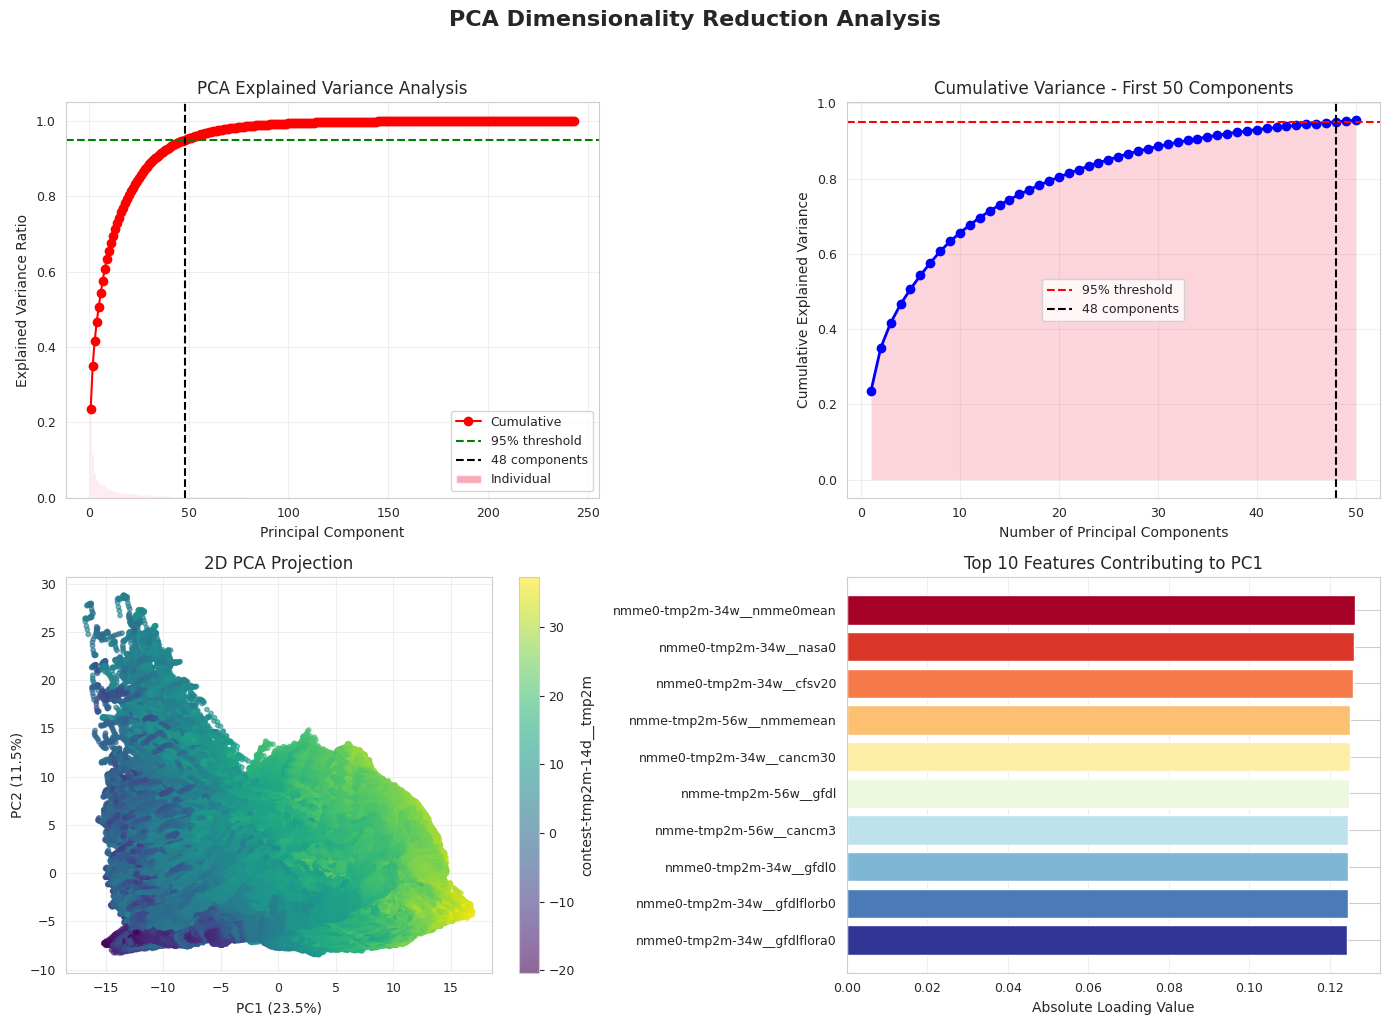


4. APPLYING PCA TRANSFORMATION
----------------------------------------
  Preserving 2 categorical features

  Dimensions before PCA: 243
  Dimensions after PCA: 51
  Cumulative explained variance: 95.048%

SAVING RESULTS

✓ Transformed data saved to: train_data_pca_reduced.csv
  New shape: (375734, 51)
✓ PCA model saved to: pca_model.pkl

DIMENSIONALITY REDUCTION SUMMARY

Original features: 245
Reduced features: 50
Compression rate: 79.6%
Information preserved: 95.05%
Components used: 48

PROCESS COMPLETED SUCCESSFULLY


In [10]:
# =============================================================================
# PCA DIMENSIONALITY REDUCTION
# =============================================================================
# This script performs PCA-based dimensionality reduction on the dataset
# Key steps:
# 1. Data preprocessing (missing values, scaling)
# 2. Determine optimal number of components
# 3. Visualize results
# 4. Apply PCA transformation
# 5. Save results and models
# =============================================================================


def pca_dimensionality_reduction(df_train, target_col=None, variance_threshold=0.95, 
                                sample_size=20000, random_state=42):
    """
    Perform PCA dimensionality reduction.
    
    Process flow:
    1. Separate features and target
    2. Handle missing values and scale features
    3. Fit PCA to determine optimal components
    4. Visualize results
    5. Transform data using optimal components
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training dataset
    target_col : str, optional
        Target variable column name (excluded from PCA)
    variance_threshold : float
        Cumulative explained variance threshold (default 0.95 = 95%)
    sample_size : int
        Sample size for PCA fitting (for large datasets)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple : (transformed_df, pca_model, scaler, loadings_df)
    """
    
    print("\n" + "="*60)
    print("PCA DIMENSIONALITY REDUCTION ANALYSIS")
    print("="*60)
    
    # -------------------------------------------------------------------------
    # STEP 1: Separate features and target variable
    # -------------------------------------------------------------------------
    if target_col and target_col in df_train.columns:
        y = df_train[target_col]
        X = df_train.drop(columns=[target_col])
        print(f"\nTarget variable: {target_col} (excluded from PCA)")
    else:
        X = df_train.copy()
        y = None
    
    # -------------------------------------------------------------------------
    # STEP 2: Data preprocessing
    # -------------------------------------------------------------------------
    print("\n1. DATA PREPROCESSING")
    print("-" * 40)
    
    # Identify numerical and categorical features
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    print(f"  Numerical features: {len(numeric_features)}")
    print(f"  Categorical features: {len(categorical_features)}")
    
    if categorical_features:
        print(f"  Categorical feature names: {categorical_features}")
    
    # Handle missing values using median imputation
    num_imputer = SimpleImputer(strategy='median')
    X_numeric_filled = pd.DataFrame(
        num_imputer.fit_transform(X[numeric_features]),
        columns=numeric_features,
        index=X.index
    )
    
    # Standardize features (crucial for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric_filled)
    
    # -------------------------------------------------------------------------
    # STEP 3: Determine optimal number of components
    # -------------------------------------------------------------------------
    print("\n2. DETERMINING OPTIMAL COMPONENTS")
    print("-" * 40)
    
    # Use sampling for large datasets to speed up computation
    if X_scaled.shape[0] > sample_size:
        np.random.seed(random_state)
        sample_idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
        X_sample = X_scaled[sample_idx]
        print(f"  Using {sample_size} samples for PCA fitting")
    else:
        X_sample = X_scaled
    
    # Fit PCA to calculate explained variance ratios
    pca_full = PCA(random_state=random_state)
    pca_full.fit(X_sample)
    
    # Calculate cumulative explained variance
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Find number of components needed to reach threshold
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    print(f"\n  Components needed for {variance_threshold:.0%} variance: {n_components}")
    print(f"  Original features: {len(numeric_features)}")
    print(f"  Dimension reduction: {(1 - n_components/len(numeric_features))*100:.1f}%")
    
    # -------------------------------------------------------------------------
    # STEP 4: Visualize PCA results
    # -------------------------------------------------------------------------
    print("\n3. VISUALIZING PCA RESULTS")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Scree plot (explained variance by component)
    ax1 = axes[0, 0]
    ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
            alpha=0.6, label='Individual')
    ax1.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
            'r-', marker='o', label='Cumulative')
    ax1.axhline(y=variance_threshold, color='g', linestyle='--', 
               label=f'{variance_threshold:.0%} threshold')
    ax1.axvline(x=n_components, color='k', linestyle='--', 
               label=f'{n_components} components')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('PCA Explained Variance Analysis')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative explained variance
    ax2 = axes[0, 1]
    n_to_show = min(50, len(cumulative_variance))
    ax2.plot(range(1, n_to_show + 1), cumulative_variance[:n_to_show], 'b-o', linewidth=2)
    ax2.fill_between(range(1, n_to_show + 1), 0, cumulative_variance[:n_to_show], alpha=0.3)
    ax2.axhline(y=variance_threshold, color='r', linestyle='--', 
               label=f'{variance_threshold:.0%} threshold')
    ax2.axvline(x=n_components, color='k', linestyle='--', 
               label=f'{n_components} components')
    ax2.set_xlabel('Number of Principal Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title(f'Cumulative Variance - First {n_to_show} Components')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: 2D PCA projection (first two components)
    ax3 = axes[1, 0]
    pca_2d = PCA(n_components=2, random_state=random_state)
    X_pca_2d = pca_2d.fit_transform(X_scaled)
    
    if y is not None:
        # Color points by target value if available
        scatter = ax3.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                             c=y, cmap='viridis', alpha=0.6, s=10)
        plt.colorbar(scatter, ax=ax3, label=target_col)
    else:
        # Use density coloring for better visualization
        if X_pca_2d.shape[0] > 10000:
            sample_idx = np.random.choice(X_pca_2d.shape[0], 10000, replace=False)
            X_sample_2d = X_pca_2d[sample_idx]
        else:
            X_sample_2d = X_pca_2d
        
        # Calculate point density
        xy = np.vstack([X_sample_2d[:, 0], X_sample_2d[:, 1]])
        z = gaussian_kde(xy)(xy)
        scatter = ax3.scatter(X_sample_2d[:, 0], X_sample_2d[:, 1], 
                             c=z, s=10, edgecolor='', cmap='viridis')
        plt.colorbar(scatter, ax=ax3, label='Density')
    
    ax3.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
    ax3.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
    ax3.set_title('2D PCA Projection')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Feature loadings for PC1
    ax4 = axes[1, 1]
    pca_loadings = PCA(n_components=min(10, len(numeric_features)), random_state=random_state)
    pca_loadings.fit(X_scaled)
    
    # Create loadings dataframe
    loadings_df = pd.DataFrame(
        pca_loadings.components_.T,
        columns=[f'PC{i+1}' for i in range(pca_loadings.n_components_)],
        index=numeric_features
    )
    
    # Get top 10 features with highest absolute loadings on PC1
    pc1_loadings = loadings_df['PC1'].abs().sort_values(ascending=False).head(10)
    
    colors = plt.cm.RdYlBu(np.linspace(0, 1, len(pc1_loadings)))
    ax4.barh(range(len(pc1_loadings)), pc1_loadings.values, color=colors)
    ax4.set_yticks(range(len(pc1_loadings)))
    ax4.set_yticklabels(pc1_loadings.index, fontsize=9)
    ax4.invert_yaxis()  # Highest at top
    ax4.set_xlabel('Absolute Loading Value')
    ax4.set_title('Top 10 Features Contributing to PC1')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('PCA Dimensionality Reduction Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------------------------
    # STEP 5: Apply PCA transformation
    # -------------------------------------------------------------------------
    print("\n4. APPLYING PCA TRANSFORMATION")
    print("-" * 40)
    
    # Fit final PCA with optimal number of components
    pca_final = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca_final.fit_transform(X_scaled)
    
    # Create dataframe with principal components
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)
    
    # Add target variable back if it exists
    if y is not None:
        X_pca_df[target_col] = y.values
    
    # Add categorical features back (not transformed by PCA)
    if categorical_features:
        print(f"  Preserving {len(categorical_features)} categorical features")
        X_pca_df = pd.concat([X_pca_df, X[categorical_features]], axis=1)
    
    print(f"\n  Dimensions before PCA: {X_scaled.shape[1]}")
    print(f"  Dimensions after PCA: {X_pca_df.shape[1]}")
    print(f"  Cumulative explained variance: {pca_final.explained_variance_ratio_.sum():.3%}")
    
    return X_pca_df, pca_final, scaler, loadings_df


# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    
    print("\n" + "="*60)
    print("STARTING DIMENSIONALITY REDUCTION PROCESS")
    print("="*60)
    
    print(f"\nOriginal dataset shape: {df_train.shape}")
        
    # target variable
    target_column = 'contest-tmp2m-14d__tmp2m'
    
    # Perform PCA dimensionality reduction
    print("\n" + "="*60)
    print("EXECUTING PCA DIMENSIONALITY REDUCTION")
    print("="*60)
    
    pca_result, pca_model, scaler_model, loadings_df = pca_dimensionality_reduction(
        df_train, 
        target_col=target_column,
        variance_threshold=0.95,  # Preserve 95% of variance
        sample_size=20000         # Use 20,000 samples for fitting
    )
    
    # -------------------------------------------------------------------------
    # SAVE RESULTS
    # -------------------------------------------------------------------------
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Save transformed dataset
    pca_result.to_csv('train_data_pca_reduced.csv', index=False)
    print(f"\n✓ Transformed data saved to: train_data_pca_reduced.csv")
    print(f"  New shape: {pca_result.shape}")
    
    # Save PCA model and transformers for future use
    model_data = {
        'pca_model': pca_model,
        'scaler': scaler_model,
        'loadings': loadings_df,
        'feature_names': df_train.drop(columns=[target_column]).select_dtypes(include=[np.number]).columns.tolist(),
        'n_components': pca_model.n_components_,
        'explained_variance_ratio': pca_model.explained_variance_ratio_.tolist()
    }
    
    joblib.dump(model_data, 'pca_model.pkl')
    print(f"✓ PCA model saved to: pca_model.pkl")
    
    # -------------------------------------------------------------------------
    # SUMMARY STATISTICS
    # -------------------------------------------------------------------------
    print("\n" + "="*60)
    print("DIMENSIONALITY REDUCTION SUMMARY")
    print("="*60)
    
    original_features = df_train.shape[1] - 1  # Excluding target
    reduced_features = pca_result.shape[1] - 1  # Excluding target
    compression_rate = (1 - reduced_features/original_features) * 100
    
    print(f"\nOriginal features: {original_features}")
    print(f"Reduced features: {reduced_features}")
    print(f"Compression rate: {compression_rate:.1f}%")
    print(f"Information preserved: {pca_model.explained_variance_ratio_.sum():.2%}")
    print(f"Components used: {pca_model.n_components_}")
    
    print("\n" + "="*60)
    print("PROCESS COMPLETED SUCCESSFULLY")
    print("="*60)

In [12]:
    # 内存使用
    print(f"\n内存使用:")
    memory_mb = df_train.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"   总内存使用: {memory_mb:.2f} MB")


内存使用:
   总内存使用: 385.19 MB


In [15]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号



print(f"数据集形状: {df_train.shape}")
print(f"列数: {len(df_train.columns)}")
print(f"目标变量: contest-tmp2m-14d__tmp2m")

数据集形状: (375734, 246)
列数: 246
目标变量: contest-tmp2m-14d__tmp2m


In [17]:
df_pca_reduced = pd.read_csv("/kaggle/input/datasets/ericrhadoophop/train-pca/train_data_pca_reduced.csv")

In [18]:
df_pca_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,contest-tmp2m-14d__tmp2m,startdate,climateregions__climateregion
0,12.141195,-0.044534,-1.947094,-3.696446,-5.341060,-1.582182,-3.480004,0.426679,0.599138,0.349987,...,0.145322,1.944152,-1.834282,-0.077937,0.379711,-1.101488,0.080997,28.744480,9/1/14,BSh
1,12.050205,-0.133470,-2.225032,-3.864371,-5.023959,-1.471996,-3.340297,1.327896,0.608503,0.529709,...,0.132981,1.960340,-1.872319,-0.055100,0.479523,-1.070445,0.107751,28.370584,9/2/14,BSh
2,11.978486,-0.242408,-2.556481,-3.954786,-4.771662,-1.414799,-3.096543,2.161906,0.646824,0.480447,...,0.089729,1.996684,-1.879166,-0.082729,0.530926,-0.966261,0.102201,28.133059,9/3/14,BSh
3,11.903324,-0.350562,-2.901346,-3.943364,-4.594294,-1.357035,-2.814464,2.788909,0.863302,0.208842,...,0.008900,1.911394,-1.806216,-0.105323,0.538040,-0.898414,0.056075,28.256798,9/4/14,BSh
4,11.837856,-0.544154,-3.258473,-3.906474,-4.576669,-1.314365,-2.634077,3.196731,1.229524,0.012638,...,0.026733,1.647992,-1.644749,-0.115708,0.258995,-0.761219,-0.005419,28.372353,9/5/14,BSh


In [20]:
df_pca_reduced.isna().sum()

PC1                              0
PC2                              0
PC3                              0
PC4                              0
PC5                              0
PC6                              0
PC7                              0
PC8                              0
PC9                              0
PC10                             0
PC11                             0
PC12                             0
PC13                             0
PC14                             0
PC15                             0
PC16                             0
PC17                             0
PC18                             0
PC19                             0
PC20                             0
PC21                             0
PC22                             0
PC23                             0
PC24                             0
PC25                             0
PC26                             0
PC27                             0
PC28                             0
PC29                

In [22]:
target = 'contest-tmp2m-14d__tmp2m'
y = df_pca_reduced[target]

# 特征选择：排除非数值列和目标变量
exclude_cols = ['index', 'lat', 'lon', 'startdate', 'climateregions__climateregion', target]
feature_cols = [col for col in df_pca_reduced.columns if col not in exclude_cols]

# 只保留数值型特征
numeric_cols = []
for col in feature_cols:
    if pd.api.types.is_numeric_dtype(df_pca_reduced[col]):
        numeric_cols.append(col)

print(f"数值型特征数量: {len(numeric_cols)}")

# 创建特征矩阵
X = df_pca_reduced[numeric_cols].copy()

数值型特征数量: 48


In [23]:
X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48
0,12.141195,-0.044534,-1.947094,-3.696446,-5.341060,-1.582182,-3.480004,0.426679,0.599138,0.349987,...,0.946792,0.575370,1.007721,0.145322,1.944152,-1.834282,-0.077937,0.379711,-1.101488,0.080997
1,12.050205,-0.133470,-2.225032,-3.864371,-5.023959,-1.471996,-3.340297,1.327896,0.608503,0.529709,...,1.089679,0.504364,1.217566,0.132981,1.960340,-1.872319,-0.055100,0.479523,-1.070445,0.107751
2,11.978486,-0.242408,-2.556481,-3.954786,-4.771662,-1.414799,-3.096543,2.161906,0.646824,0.480447,...,0.953675,0.381057,1.266165,0.089729,1.996684,-1.879166,-0.082729,0.530926,-0.966261,0.102201
3,11.903324,-0.350562,-2.901346,-3.943364,-4.594294,-1.357035,-2.814464,2.788909,0.863302,0.208842,...,0.781347,0.288811,1.333080,0.008900,1.911394,-1.806216,-0.105323,0.538040,-0.898414,0.056075
4,11.837856,-0.544154,-3.258473,-3.906474,-4.576669,-1.314365,-2.634077,3.196731,1.229524,0.012638,...,0.647780,0.044993,1.194312,0.026733,1.647992,-1.644749,-0.115708,0.258995,-0.761219,-0.005419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375729,7.515891,0.602703,-0.131454,-4.715802,0.704583,0.601310,-1.113141,-0.953901,-0.817780,-2.187229,...,0.880196,0.670905,0.660805,-0.417671,1.148785,-0.917644,0.001512,-0.942441,0.106558,0.115687
375730,7.325908,0.390913,-0.528741,-4.498628,0.953277,0.763563,-1.175671,-0.875020,-1.199689,-2.146221,...,0.624903,0.413257,0.531944,-0.514022,1.473689,-1.111245,0.084862,-0.953705,-0.197998,0.023980
375731,7.131473,0.232950,-0.816959,-4.195534,1.242083,0.814841,-1.405438,-0.908142,-1.386496,-1.985101,...,0.196307,0.667139,0.303800,-0.588489,1.656827,-1.171212,0.003653,-1.120244,-0.296047,-0.070564
375732,6.855428,0.100423,-0.934937,-3.863263,1.409450,0.808267,-1.624728,-1.110498,-1.608316,-1.758502,...,-0.226600,1.123098,0.137941,-0.641672,1.787515,-1.275273,0.051786,-1.242532,-0.346044,0.012069


In [24]:
y

0         28.744480
1         28.370584
2         28.133059
3         28.256798
4         28.372353
            ...    
375729    17.150955
375730    16.962051
375731    16.915474
375732    16.536760
375733    15.910996
Name: contest-tmp2m-14d__tmp2m, Length: 375734, dtype: float64

Calculate the Pearson correlation coefficient


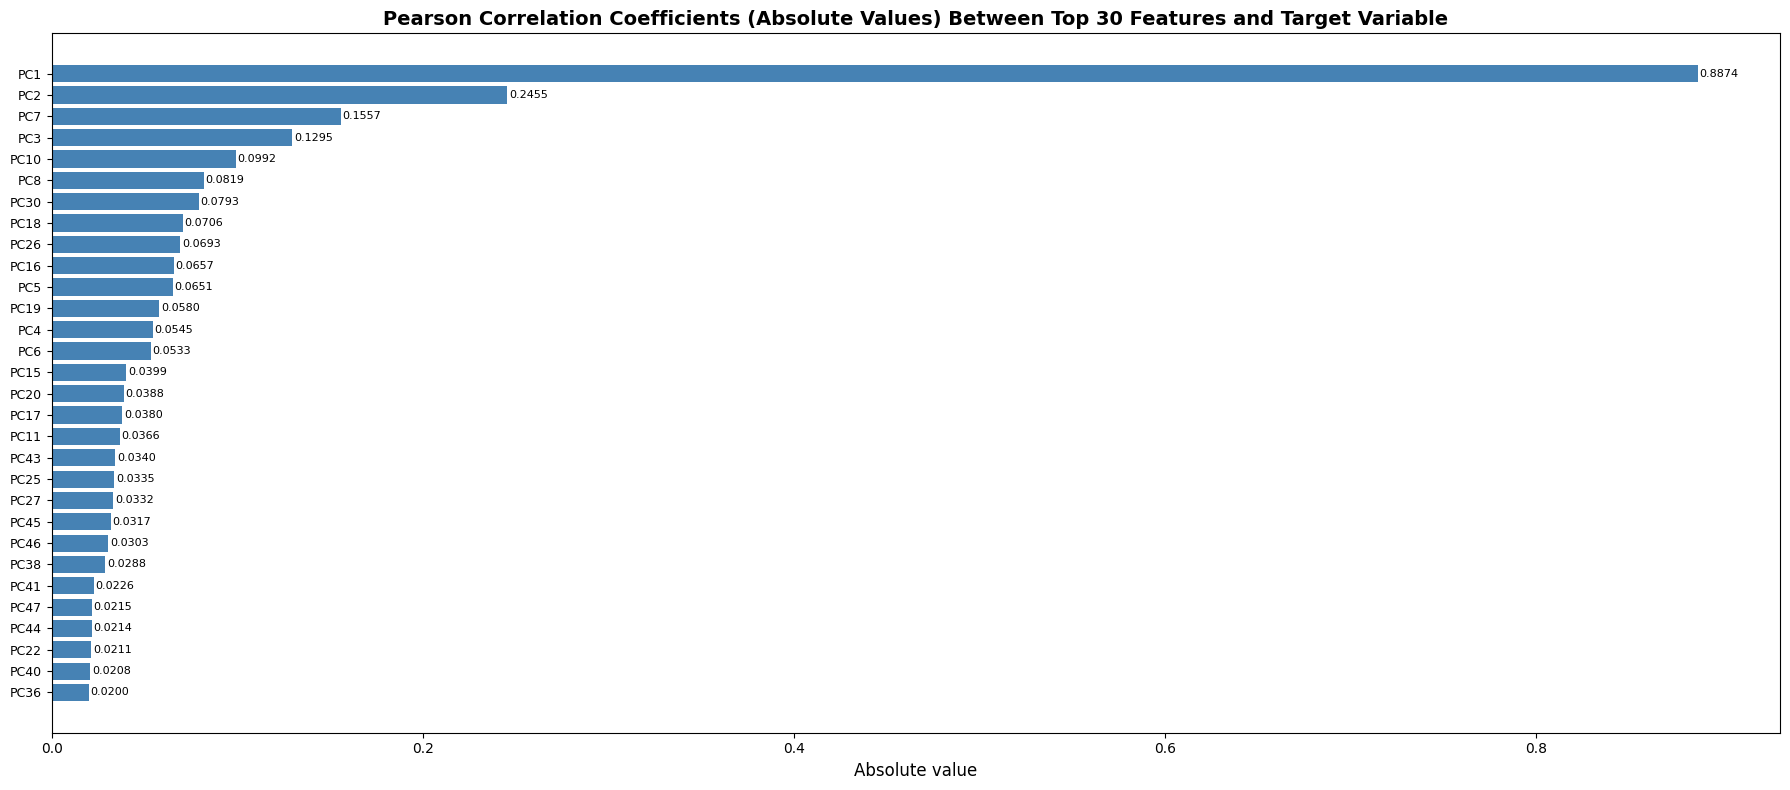

In [58]:
# viualization
def plot_top_features(feature_scores, title, top_n=30, figsize=(15, 10)):
    """绘制特征重要性/相关性排序图"""
    top_features = feature_scores[:top_n]
    features = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]

    plt.figure(figsize=figsize)
    bars = plt.barh(range(len(features)), scores, color='steelblue')
    plt.yticks(range(len(features)), features, fontsize=10)
    plt.xlabel('重要性/相关性分数', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # The most important feature is at the top.

    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
                f'{score:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    return plt

fig, ax = plt.subplots(1, 1, figsize=(18, 8))  # 调整高度更合适

# 1. 计算皮尔逊相关系数
print("Calculate the Pearson correlation coefficient")
correlations = []
for col in numeric_cols:
    if col != target and col in X.columns:
        corr = np.corrcoef(X[col], y)[0, 1]
        if not np.isnan(corr):
            correlations.append((col, abs(corr)))

# 按相关性绝对值排序
correlations_sorted = sorted(correlations, key=lambda x: x[1], reverse=True)

# 1. Pearson correlation coefficient
top_corr = correlations_sorted[:30]
corr_features = [f[0] for f in top_corr]
corr_scores = [f[1] for f in top_corr]

ax.barh(range(len(corr_features)), corr_scores, color='steelblue')
ax.set_yticks(range(len(corr_features)))
ax.set_yticklabels(corr_features, fontsize=9)
ax.set_xlabel('Absolute value', fontsize=12)
ax.set_title('Pearson Correlation Coefficients (Absolute Values) Between Top 30 Features and Target Variable', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i, (feature, score) in enumerate(top_corr):
    ax.text(score + 0.001, i, f'{score:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [21]:


# 2. RF calculate feature importance
print("Calculating Feature Importance Using Random Forests")
# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

# 获取特征重要性
feature_importance = list(zip(numeric_cols, rf.feature_importances_))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# 3.Using mutual information to calculate nonlinear correlations
from sklearn.feature_selection import mutual_info_regression

print("Calculate mutual information")
# 只计算前100个特征与目标的相关性
top_100_features = [col for col, _ in correlations_sorted[:100]]
mi_scores = mutual_info_regression(X[top_100_features], y, random_state=42)
mi_features = list(zip(top_100_features, mi_scores))
mi_features_sorted = sorted(mi_features, key=lambda x: x[1], reverse=True)

# viualization
def plot_top_features(feature_scores, title, top_n=30, figsize=(15, 10)):
    """绘制特征重要性/相关性排序图"""
    top_features = feature_scores[:top_n]
    features = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]

    plt.figure(figsize=figsize)
    bars = plt.barh(range(len(features)), scores, color='steelblue')
    plt.yticks(range(len(features)), features, fontsize=10)
    plt.xlabel('重要性/相关性分数', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # The most important feature is at the top.

    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
                f'{score:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    return plt

fig, axes = plt.subplots(3, 1, figsize=(18, 24))

# 1. Pearson correlation coefficient
top_corr = correlations_sorted[:30]
corr_features = [f[0] for f in top_corr]
corr_scores = [f[1] for f in top_corr]

axes[0].barh(range(len(corr_features)), corr_scores, color='steelblue')
axes[0].set_yticks(range(len(corr_features)))
axes[0].set_yticklabels(corr_features, fontsize=9)
axes[0].set_xlabel('绝对值', fontsize=12)
axes[0].set_title('Pearson Correlation Coefficients (Absolute Values) Between Top 30 Features and Target Variable', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

for i, (feature, score) in enumerate(top_corr):
    axes[0].text(score + 0.001, i, f'{score:.4f}', va='center', fontsize=8)

# 2. Feature Importance in Random Forests
top_rf = feature_importance_sorted[:30]
rf_features = [f[0] for f in top_rf]
rf_scores = [f[1] for f in top_rf]

axes[1].barh(range(len(rf_features)), rf_scores, color='darkorange')
axes[1].set_yticks(range(len(rf_features)))
axes[1].set_yticklabels(rf_features, fontsize=9)
axes[1].set_xlabel('重要性分数', fontsize=12)
axes[1].set_title('Top 30 特征 - 随机森林重要性', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# 添加数值标签
for i, (feature, score) in enumerate(top_rf):
    axes[1].text(score + 0.0001, i, f'{score:.4f}', va='center', fontsize=8)

# 3. Mutual Information
top_mi = mi_features_sorted[:30]
mi_features_names = [f[0] for f in top_mi]
mi_scores_values = [f[1] for f in top_mi]

axes[2].barh(range(len(mi_features_names)), mi_scores_values, color='forestgreen')
axes[2].set_yticks(range(len(mi_features_names)))
axes[2].set_yticklabels(mi_features_names, fontsize=9)
axes[2].set_xlabel('互信息分数', fontsize=12)
axes[2].set_title('Top 30 特征 - 互信息（非线性相关性）', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()

for i, (feature, score) in enumerate(top_mi):
    axes[2].text(score + 0.0001, i, f'{score:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# 4. merge methods
print("\n" + "="*80)
print("特征重要性综合分析")
print("="*80)

# Create a comprehensive score
feature_scores_dict = {}

# Score each feature's ranking across the three methods
for method_name, method_results in [
    ("相关性", correlations_sorted),
    ("随机森林", feature_importance_sorted),
    ("互信息", mi_features_sorted + [(f, 0) for f in numeric_cols if f not in top_100_features])
]:
    for rank, (feature, score) in enumerate(method_results):
        if feature not in feature_scores_dict:
            feature_scores_dict[feature] = {"scores": [], "ranks": []}

        # 转换为排名分数 (1/rank)，排名越高分数越高
        if rank < 100:
            rank_score = 1/(rank+1)
            feature_scores_dict[feature]["scores"].append(score)
            feature_scores_dict[feature]["ranks"].append(rank_score)

# Calculate the composite score
composite_scores = []
for feature, data in feature_scores_dict.items():
    if len(data["ranks"]) >= 2:  # 至少出现在两种方法中
        avg_rank = np.mean(data["ranks"])
        composite_scores.append((feature, avg_rank))

# Sorted by overall score
composite_scores_sorted = sorted(composite_scores, key=lambda x: x[1], reverse=True)

# Importance Chart
plt.figure(figsize=(16, 12))
top_composite = composite_scores_sorted[:40]
composite_features = [f[0] for f in top_composite]
composite_values = [f[1] for f in top_composite]

bars = plt.barh(range(len(composite_features)), composite_values, color='purple')
plt.yticks(range(len(composite_features)), composite_features, fontsize=10)
plt.xlabel('综合重要性分数', fontsize=12)
plt.title('Top 40 Features - Comprehensive Importance Ranking (Based on Three Methods)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()


for i, (bar, score) in enumerate(zip(bars, composite_values)):
    plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 5. Analyze the most important feature types
print("\n" + "="*80)
print("最重要特征类型分析")
print("="*80)

# Analyze the types of the top 20 most important features
top_20_features = [f[0] for f in composite_scores_sorted[:20]]

feature_categories = {
    "NMME温度预测": [],
    "NMME降水预测": [],
    "风场相关": [],
    "海温相关": [],
    "海冰相关": [],
    "气压相关": [],
    "其他": []
}

for feature in top_20_features:
    if any(prefix in feature for prefix in ['nmme0-tmp2m', 'nmme-tmp2m', 'cancm', 'ccsm', 'cfsv', 'gfdl', 'nasa']):
        if 'tmp2m' in feature or any(model in feature for model in ['cancm', 'ccsm', 'cfsv', 'gfdl', 'nasa']):
            feature_categories["NMME温度预测"].append(feature)
        elif 'prate' in feature:
            feature_categories["NMME降水预测"].append(feature)
        else:
            feature_categories["其他"].append(feature)
    elif 'wind' in feature:
        feature_categories["风场相关"].append(feature)
    elif 'sst' in feature:
        feature_categories["海温相关"].append(feature)
    elif 'icec' in feature:
        feature_categories["海冰相关"].append(feature)
    elif 'pres' in feature or 'slp' in feature:
        feature_categories["气压相关"].append(feature)
    else:
        feature_categories["其他"].append(feature)

# 打印分类结果
for category, features in feature_categories.items():
    if features:
        print(f"\n{category} ({len(features)}个):")
        for feature in features:
            print(f"  - {feature}")

# 6. Detailed Analysis of the Most Relevant Features
print("\n" + "="*80)
print("与目标变量最相关的10个特征（皮尔逊相关系数）")
print("="*80)

for i, (feature, corr) in enumerate(correlations_sorted[:10]):
    # Calculate the actual correlation coefficient
    actual_corr = np.corrcoef(X[feature], y)[0, 1]
    print(f"{i+1}. {feature}:")
    print(f"   相关系数: {actual_corr:.4f} (绝对值: {corr:.4f})")
    print(f"   均值: {X[feature].mean():.4f}, 标准差: {X[feature].std():.4f}")
    print(f"   最小值: {X[feature].min():.4f}, 最大值: {X[feature].max():.4f}")
    print()



plt.tight_layout()
plt.show()


数值型特征数量: 48
Calculate the Pearson correlation coefficient
Calculating Feature Importance Using Random Forests


KeyboardInterrupt: 

In [13]:


target = 'contest-tmp2m-14d__tmp2m'
y = df_train[target]

# 特征选择：排除非数值列和目标变量
exclude_cols = ['index', 'lat', 'lon', 'startdate', 'climateregions__climateregion', target]
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

# 只保留数值型特征
numeric_cols = []
for col in feature_cols:
    if pd.api.types.is_numeric_dtype(df_train[col]):
        numeric_cols.append(col)

print(f"数值型特征数量: {len(numeric_cols)}")

# 创建特征矩阵
X = df_train[numeric_cols].copy()

# 处理缺失值
X = X.fillna(X.mean())

# 1. 计算皮尔逊相关系数
print("Calculate the Pearson correlation coefficient")
correlations = []
for col in numeric_cols:
    if col != target and col in X.columns:
        corr = np.corrcoef(X[col], y)[0, 1]
        if not np.isnan(corr):
            correlations.append((col, abs(corr)))

# 按相关性绝对值排序
correlations_sorted = sorted(correlations, key=lambda x: x[1], reverse=True)

# 2. RF calculate feature importance
print("Calculating Feature Importance Using Random Forests")
# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

# 获取特征重要性
feature_importance = list(zip(numeric_cols, rf.feature_importances_))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# 3.Using mutual information to calculate nonlinear correlations
from sklearn.feature_selection import mutual_info_regression

print("Calculate mutual information")
# 只计算前100个特征与目标的相关性
top_100_features = [col for col, _ in correlations_sorted[:100]]
mi_scores = mutual_info_regression(X[top_100_features], y, random_state=42)
mi_features = list(zip(top_100_features, mi_scores))
mi_features_sorted = sorted(mi_features, key=lambda x: x[1], reverse=True)

# viualization
def plot_top_features(feature_scores, title, top_n=30, figsize=(15, 10)):
    """绘制特征重要性/相关性排序图"""
    top_features = feature_scores[:top_n]
    features = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]

    plt.figure(figsize=figsize)
    bars = plt.barh(range(len(features)), scores, color='steelblue')
    plt.yticks(range(len(features)), features, fontsize=10)
    plt.xlabel('重要性/相关性分数', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # The most important feature is at the top.

    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
                f'{score:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    return plt

fig, axes = plt.subplots(3, 1, figsize=(18, 24))

# 1. Pearson correlation coefficient
top_corr = correlations_sorted[:30]
corr_features = [f[0] for f in top_corr]
corr_scores = [f[1] for f in top_corr]

axes[0].barh(range(len(corr_features)), corr_scores, color='steelblue')
axes[0].set_yticks(range(len(corr_features)))
axes[0].set_yticklabels(corr_features, fontsize=9)
axes[0].set_xlabel('绝对值', fontsize=12)
axes[0].set_title('Pearson Correlation Coefficients (Absolute Values) Between Top 30 Features and Target Variable', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

for i, (feature, score) in enumerate(top_corr):
    axes[0].text(score + 0.001, i, f'{score:.4f}', va='center', fontsize=8)

# 2. Feature Importance in Random Forests
top_rf = feature_importance_sorted[:30]
rf_features = [f[0] for f in top_rf]
rf_scores = [f[1] for f in top_rf]

axes[1].barh(range(len(rf_features)), rf_scores, color='darkorange')
axes[1].set_yticks(range(len(rf_features)))
axes[1].set_yticklabels(rf_features, fontsize=9)
axes[1].set_xlabel('重要性分数', fontsize=12)
axes[1].set_title('Top 30 特征 - 随机森林重要性', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# 添加数值标签
for i, (feature, score) in enumerate(top_rf):
    axes[1].text(score + 0.0001, i, f'{score:.4f}', va='center', fontsize=8)

# 3. Mutual Information
top_mi = mi_features_sorted[:30]
mi_features_names = [f[0] for f in top_mi]
mi_scores_values = [f[1] for f in top_mi]

axes[2].barh(range(len(mi_features_names)), mi_scores_values, color='forestgreen')
axes[2].set_yticks(range(len(mi_features_names)))
axes[2].set_yticklabels(mi_features_names, fontsize=9)
axes[2].set_xlabel('互信息分数', fontsize=12)
axes[2].set_title('Top 30 特征 - 互信息（非线性相关性）', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()

for i, (feature, score) in enumerate(top_mi):
    axes[2].text(score + 0.0001, i, f'{score:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# 4. merge methods
print("\n" + "="*80)
print("特征重要性综合分析")
print("="*80)

# Create a comprehensive score
feature_scores_dict = {}

# Score each feature's ranking across the three methods
for method_name, method_results in [
    ("相关性", correlations_sorted),
    ("随机森林", feature_importance_sorted),
    ("互信息", mi_features_sorted + [(f, 0) for f in numeric_cols if f not in top_100_features])
]:
    for rank, (feature, score) in enumerate(method_results):
        if feature not in feature_scores_dict:
            feature_scores_dict[feature] = {"scores": [], "ranks": []}

        # 转换为排名分数 (1/rank)，排名越高分数越高
        if rank < 100:
            rank_score = 1/(rank+1)
            feature_scores_dict[feature]["scores"].append(score)
            feature_scores_dict[feature]["ranks"].append(rank_score)

# Calculate the composite score
composite_scores = []
for feature, data in feature_scores_dict.items():
    if len(data["ranks"]) >= 2:  # 至少出现在两种方法中
        avg_rank = np.mean(data["ranks"])
        composite_scores.append((feature, avg_rank))

# Sorted by overall score
composite_scores_sorted = sorted(composite_scores, key=lambda x: x[1], reverse=True)

# Importance Chart
plt.figure(figsize=(16, 12))
top_composite = composite_scores_sorted[:40]
composite_features = [f[0] for f in top_composite]
composite_values = [f[1] for f in top_composite]

bars = plt.barh(range(len(composite_features)), composite_values, color='purple')
plt.yticks(range(len(composite_features)), composite_features, fontsize=10)
plt.xlabel('综合重要性分数', fontsize=12)
plt.title('Top 40 Features - Comprehensive Importance Ranking (Based on Three Methods)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()


for i, (bar, score) in enumerate(zip(bars, composite_values)):
    plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 5. Analyze the most important feature types
print("\n" + "="*80)
print("最重要特征类型分析")
print("="*80)

# Analyze the types of the top 20 most important features
top_20_features = [f[0] for f in composite_scores_sorted[:20]]

feature_categories = {
    "NMME温度预测": [],
    "NMME降水预测": [],
    "风场相关": [],
    "海温相关": [],
    "海冰相关": [],
    "气压相关": [],
    "其他": []
}

for feature in top_20_features:
    if any(prefix in feature for prefix in ['nmme0-tmp2m', 'nmme-tmp2m', 'cancm', 'ccsm', 'cfsv', 'gfdl', 'nasa']):
        if 'tmp2m' in feature or any(model in feature for model in ['cancm', 'ccsm', 'cfsv', 'gfdl', 'nasa']):
            feature_categories["NMME温度预测"].append(feature)
        elif 'prate' in feature:
            feature_categories["NMME降水预测"].append(feature)
        else:
            feature_categories["其他"].append(feature)
    elif 'wind' in feature:
        feature_categories["风场相关"].append(feature)
    elif 'sst' in feature:
        feature_categories["海温相关"].append(feature)
    elif 'icec' in feature:
        feature_categories["海冰相关"].append(feature)
    elif 'pres' in feature or 'slp' in feature:
        feature_categories["气压相关"].append(feature)
    else:
        feature_categories["其他"].append(feature)

# 打印分类结果
for category, features in feature_categories.items():
    if features:
        print(f"\n{category} ({len(features)}个):")
        for feature in features:
            print(f"  - {feature}")

# 6. Detailed Analysis of the Most Relevant Features
print("\n" + "="*80)
print("与目标变量最相关的10个特征（皮尔逊相关系数）")
print("="*80)

for i, (feature, corr) in enumerate(correlations_sorted[:10]):
    # Calculate the actual correlation coefficient
    actual_corr = np.corrcoef(X[feature], y)[0, 1]
    print(f"{i+1}. {feature}:")
    print(f"   相关系数: {actual_corr:.4f} (绝对值: {corr:.4f})")
    print(f"   均值: {X[feature].mean():.4f}, 标准差: {X[feature].std():.4f}")
    print(f"   最小值: {X[feature].min():.4f}, 最大值: {X[feature].max():.4f}")
    print()



plt.tight_layout()
plt.show()


数据集形状: (375734, 246)
列数: 246
目标变量: contest-tmp2m-14d__tmp2m
数值型特征数量: 240
Calculate the Pearson correlation coefficient
Calculating Feature Importance Using Random Forests


KeyboardInterrupt: 